<a href="https://colab.research.google.com/github/yohanesnuwara/volve-machine-learning/blob/main/notebook/spe_data_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
import seaborn as sns
import scipy as sp
plt.rcParams['font.size'] = 20

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import validation_curve, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [24]:
# # This function I made to pre-process the dataset. Activate this cell to see
# # how I prepared this data

# def load_and_preprocess():
#   # Data URL
#   url = 'https://raw.githubusercontent.com/yohanesnuwara/energy-analysis/main/data/SPE_welldata_string_preprocessed.csv'

#   # Read data
#   df = pd.read_csv(url)

#   # Remove columns with almost all values are NaN
#   column_nan = ['Pre-Refrac Completion # Stages', 'Pre-Refrac Completion # Clusters ',
#                 'Initian Completion # Clusters per Stage', 'Condensate Yield (Bc/MMcf)',
#                 ' Dew Point Pressure (psi) ', ' Initial GOR (scf/bbl) ', 
#                 ' Bubble Point Pressure (psi) ', ' Spacing ', 'Total Fluid (Bbls)',
#                 ' Tubing ID (in) ', ' Tubing OD (in) ', ' Tubing Depth (ft) ']
#   df = df.drop(column_nan, axis=1)

#   # Drop unwanted columns
#   column_object = [' Configuration ', 'Production Path', 'Pressure Loss Correlation',
#                    'Well Number', 'State', ' Initial Pressure Estimate (psi) ']
#   df = df.drop(column_object, axis=1)
#   df = df.iloc[:,:27]

#   return df

# # Execute pre-processing function
# wells = load_and_preprocess()

# wells.head()

In [25]:
# This is the ready-to-use version of that data already converted to CSV.
# Load this instead to skip pre-processing steps above.
url = 'https://raw.githubusercontent.com/yohanesnuwara/energy-analysis/main/data/SPE_ML_data.csv'

wells = pd.read_csv(url)
wells.head()

,Lease,Formation/Reservoir,Reservoir Temperature (deg F),Net Pay (ft),Wellbore Diameter (ft),Porosity,Water Saturation,Oil Saturation,Gas Saturation,Gas Specific Gravity,CO2,H2S,N2,Condensate Gravity (API),Sep. Temperature (deg F),Sep. Pressure (psi),Oil Gravity (API),TVD (ft),# Stages,# Clusters,# Clusters per Stage,# of Total Proppant (Lbs),Lateral Length (ft),Top Perf (ft),Bottom Perf (ft),Sandface Temp (deg F),Static Wellhead Temp (deg F)
0,OSPREY,EAGLE FORD,225,78,0.7,0.063,0.260,0.740,0.0,0.9513,0.0217,0.0,0.0045,37.29,100,100,37.29,7638.6000,28,252,9.0,13514540.0,5883,8030,13913,225.0,70.0
1,FALCON,EAGLE FORD,225,66,0.7,0.063,0.270,0.730,0.0,0.9936,0.0217,0.0,0.0045,34.60,100,100,34.60,7501.8758,64,960,15.0,35970960.0,9997,7828,17825,225.0,60.0
2,HAWK,EAGLE FORD,225,67,0.7,0.063,0.271,0.729,0.0,0.9936,0.0217,0.0,0.0045,34.60,100,100,34.60,7516.6753,68,1020,15.0,38064782.0,10672,7824,18496,225.0,60.0
3,EAGLE,EAGLE FORD,235,74,0.7,0.063,0.270,0.730,0.0,0.9200,0.0204,0.0,0.0019,35.46,100,100,35.46,7890.8100,50,450,9.0,25267400.0,7481,7958,15439,234.0,60.0
4,KITE,EAGLE FORD,238,56,0.7,0.050,0.321,0.679,0.0,0.7200,0.0000,0.0,0.0000,43.58,100,100,43.58,8846.8300,34,306,9.0,18554774.0,5086,9388,14474,235.0,65.0


In [26]:
# Summary stats of data
wells.describe()

,Reservoir Temperature (deg F),Net Pay (ft),Wellbore Diameter (ft),Porosity,Water Saturation,Oil Saturation,Gas Saturation,Gas Specific Gravity,CO2,H2S,N2,Condensate Gravity (API),Sep. Temperature (deg F),Sep. Pressure (psi),Oil Gravity (API),TVD (ft),# Stages,# Clusters,# Clusters per Stage,# of Total Proppant (Lbs),Lateral Length (ft),Top Perf (ft),Bottom Perf (ft),Sandface Temp (deg F),Static Wellhead Temp (deg F)
count,53.000000,53.000000,5.300000e+01,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.0,53.000000,53.000000,53.0,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,5.300000e+01,53.000000,53.000000,53.000000,53.000000,53.000000
mean,211.867925,157.830189,7.000000e-01,0.069975,0.300292,0.141591,0.558117,0.632104,0.011787,0.0,0.000457,31.472264,100.0,100.0,683.096792,8951.992571,46.415094,317.698113,6.583208,2.150203e+07,8019.075472,9133.905660,17136.566038,210.388062,94.067925
std,90.743306,59.686597,1.120847e-16,0.013347,0.085137,0.279971,0.298433,0.123978,0.017639,0.0,0.001102,4.904984,0.0,0.0,3412.046584,2118.391195,20.147947,231.010122,2.954808,9.572924e+06,2371.435964,2179.193484,3521.258699,88.773573,48.508345
min,115.000000,56.000000,7.000000e-01,0.050000,0.183800,0.000000,0.000000,0.570000,0.000000,0.0,0.000000,30.000000,100.0,100.0,30.000000,5707.639000,7.000000,49.000000,3.000000,3.591544e+06,2268.000000,5900.000000,10049.000000,115.000000,60.000000
25%,134.000000,134.000000,7.000000e-01,0.060300,0.210000,0.000000,0.564100,0.570000,0.000000,0.0,0.000000,30.000000,100.0,100.0,30.000000,7441.235000,31.000000,141.000000,5.000000,1.416337e+07,6098.000000,7550.000000,14474.000000,134.000000,60.000000
50%,146.000000,164.000000,7.000000e-01,0.067200,0.309300,0.000000,0.651600,0.570000,0.000000,0.0,0.000000,30.000000,100.0,100.0,30.000000,7698.570000,48.000000,235.000000,5.000000,2.083679e+07,7574.000000,8030.000000,16226.000000,143.366600,80.000000
75%,305.000000,208.000000,7.000000e-01,0.083900,0.361000,0.000000,0.790000,0.598000,0.024500,0.0,0.000500,30.000000,100.0,100.0,30.000000,11675.933900,64.000000,450.000000,7.000000,2.669545e+07,9856.000000,11902.000000,19959.000000,300.000000,120.000000
max,379.000000,268.000000,7.000000e-01,0.100000,0.470000,0.740000,0.816200,0.993600,0.058000,0.0,0.004500,60.000000,100.0,100.0,21274.300000,12668.000000,89.000000,1035.000000,15.000000,4.294695e+07,13011.000000,13153.000000,23203.000000,379.000000,236.000000


In [27]:
def sort_values(df, column_to_sort, ascending=True):
  sorted_df = df.sort_values(column_to_sort, ascending=ascending)
  sorted_df = sorted_df[['Lease', column_to_sort]]
  return sorted_df

In [28]:
# Sort leases from largest to smallest cluster per stage
sorted_df = sort_values(wells, '# Clusters per Stage', ascending=False)

sorted_df.head(10)

,Lease,# Clusters per Stage
8,CARDINAL,15.0
2,HAWK,15.0
1,FALCON,15.0
10,CROW,15.0
7,LARK,9.0
9,JAY,9.0
0,OSPREY,9.0
6,SPARROW,9.0
5,SWIFT,9.0
4,KITE,9.0


In [29]:
def corrcoef_heatmap(df, vmin=-0.5, vmax=0.5):
  # Generate a mask for the upper triangle
  mask = np.zeros_like(df.corr(method = 'spearman') , dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Draw the heatmap with the mask and correct aspect ratio
  plt.figure(figsize=(12,10))
  h = sns.heatmap(df.corr(method = 'spearman'),  mask=mask, cmap='Spectral_r', 
              vmin=vmin, vmax=vmax, square=True)
  plt.show()  

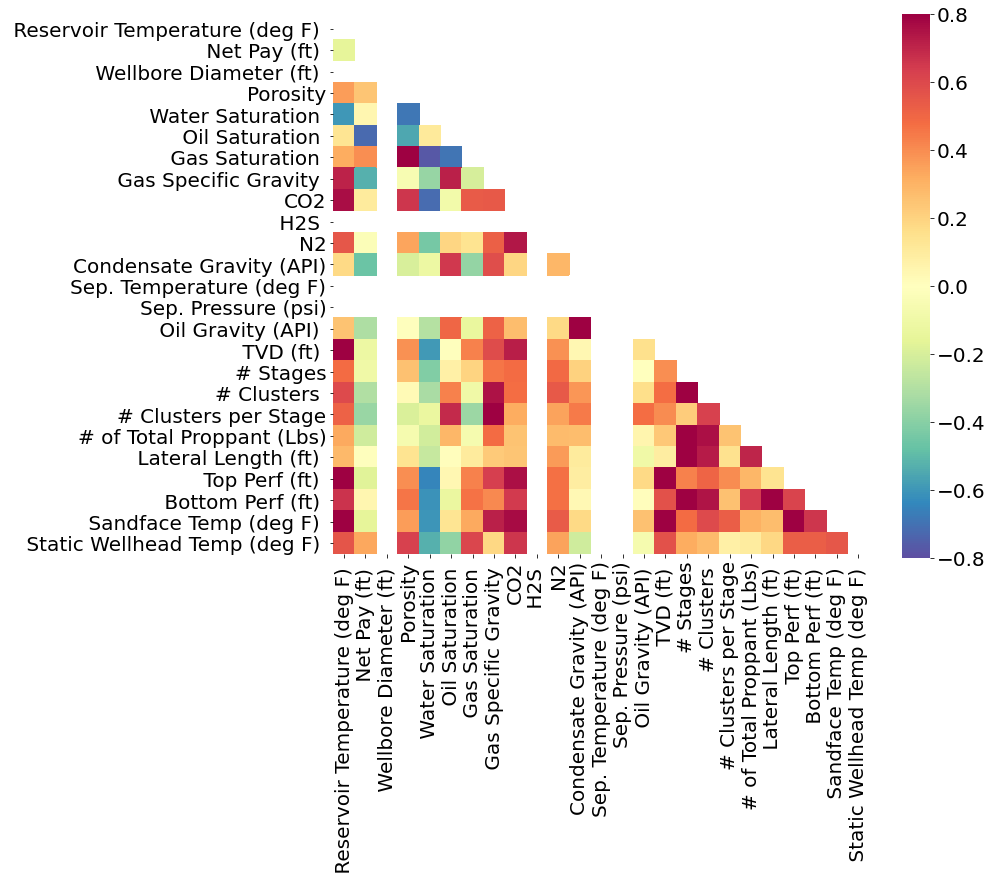

In [30]:
corrcoef_heatmap(wells, vmin=-0.8, vmax=0.8)

In [9]:
def t_test(N, alpha=0.05):
  # Default 5% confidence level
  t = sp.stats.t.isf(alpha/2, N-2)
  r_crit = t/np.sqrt((N-2)+ np.power(t,2))
  return r_crit

In [10]:
# t-test
N = len(wells) # number of leases
r_crit = t_test(N)

r_crit

0.2706277769651513

In [11]:
# Drop uncorrelated features
uncorrelated_features = [' Wellbore Diameter (ft) ', 'Porosity', ' Water Saturation ', 
                         'Sep. Temperature (deg F)', 'Sep. Pressure (psi)', 
                         '# Stages', '# Clusters ', ' Sandface Temp (deg F) ', 
                         ' Static Wellhead Temp (deg F) ', 'Condensate Gravity (API)',
                         ' H2S ', '# of Total Proppant (Lbs)']

wells = wells.drop(uncorrelated_features, axis=1)

In [12]:
# Encode formation column
le = LabelEncoder()
wells['Formation/Reservoir'] = le.fit_transform(wells['Formation/Reservoir'].values)

wells.head()

,Lease,Formation/Reservoir,Reservoir Temperature (deg F),Net Pay (ft),Oil Saturation,Gas Saturation,Gas Specific Gravity,CO2,N2,Oil Gravity (API),TVD (ft),# Clusters per Stage,Lateral Length (ft),Top Perf (ft),Bottom Perf (ft)
0,OSPREY,1,225,78,0.740,0.0,0.9513,0.0217,0.0045,37.29,7638.6000,9.0,5883,8030,13913
1,FALCON,1,225,66,0.730,0.0,0.9936,0.0217,0.0045,34.60,7501.8758,15.0,9997,7828,17825
2,HAWK,1,225,67,0.729,0.0,0.9936,0.0217,0.0045,34.60,7516.6753,15.0,10672,7824,18496
3,EAGLE,1,235,74,0.730,0.0,0.9200,0.0204,0.0019,35.46,7890.8100,9.0,7481,7958,15439
4,KITE,1,238,56,0.679,0.0,0.7200,0.0000,0.0000,43.58,8846.8300,9.0,5086,9388,14474


In [13]:
# Splitting features and targets
df = wells.iloc[:,1:] # Ignoring lease name

target_feature = '# Clusters per Stage'
X = df.drop([target_feature], axis=1)
y = df[target_feature]

In [14]:
def scores(param_name, param_range):
  model = DecisionTreeRegressor(random_state=5)
  scorer = make_scorer(mean_squared_error)

  # LOOCV is CV with N folds. N number of data = 43
  train_scores, test_scores = validation_curve(model, X, y,
                                               param_name=param_name,
                                               param_range=param_range,
                                               cv=53, scoring=scorer)

  train_score = np.mean(train_scores, axis=1)
  test_score = np.mean(test_scores, axis=1)  
  return train_score, test_score 

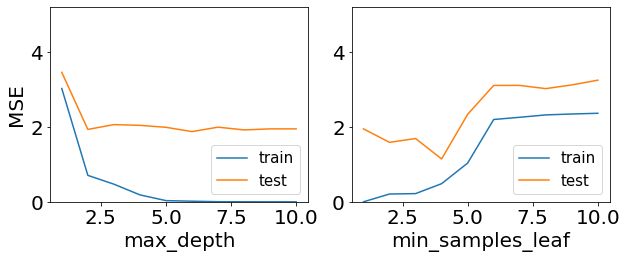

In [15]:
plt.rcParams['font.size'] = 20

# Range for parameters
param_range = [1,2,3,4,5,6,7,8,9,10]

# Scores for varying max_depth
train_score1, test_score1 = scores('max_depth', param_range)

# Scores for varying min_samples_leaf
train_score2, test_score2 = scores('min_samples_leaf', param_range)

# Plot validation curves
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(param_range, train_score1, label='train')
plt.plot(param_range, test_score1, label='test')
plt.ylim(0,5.2)
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='lower right', fontsize=15)

plt.subplot(1,2,2)
plt.plot(param_range, train_score2, label='train')
plt.plot(param_range, test_score2, label='test')
plt.ylim(0,5.2)
plt.xlabel('min_samples_leaf')
plt.legend(loc='lower right', fontsize=15)

plt.tight_layout()
plt.show()

In [16]:
# BOSSIER_SHALE: 0, EAGLE FORD: 1, HAYNESVILLE SHALE: 2, 
# MARCELLUS: 3, MARCELLUS_UPPER: 4 

def predict(model, formation, temp, netpay, oilsat, gassat, sg, 
            co2, n2, oilapi, tvd, lateral, topperf, botperf):
  X_test = np.array([formation, temp, netpay, oilsat, gassat, sg,
                    co2, n2, oilapi, tvd, lateral, topperf, botperf])
  X_test = X_test.reshape(1,-1)

  # model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, random_state=5)
  # model.fit(X, y)
  y_pred = model.predict(X_test)
  return y_pred

In [17]:
# Predict on new input

# Define model
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, random_state=5)

# Fit model to data
dt = dt.fit(X, y)

# New input
formation = 3
temp = 150
netpay = 130
oilsat = 0 
gassat = 0.6
sg = 0.6
co2 = 0.03
n2 = 0.004
oilapi = 30 
tvd = 8000
lateral = 2000
topperf = 6000
botperf = 16000

predict(dt, formation, temp, netpay, oilsat, gassat, sg, co2, n2, oilapi, 
        tvd, lateral, topperf, botperf)

array([7.])

In [18]:
def visualize(model):
  # regr = DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, random_state=5)
  # model = regr.fit(X, y)
  text_representation = tree.export_text(model)
  fig = plt.figure(figsize=(35,20))
  _ = tree.plot_tree(model, feature_names=X.columns.values, filled=True, fontsize=13)

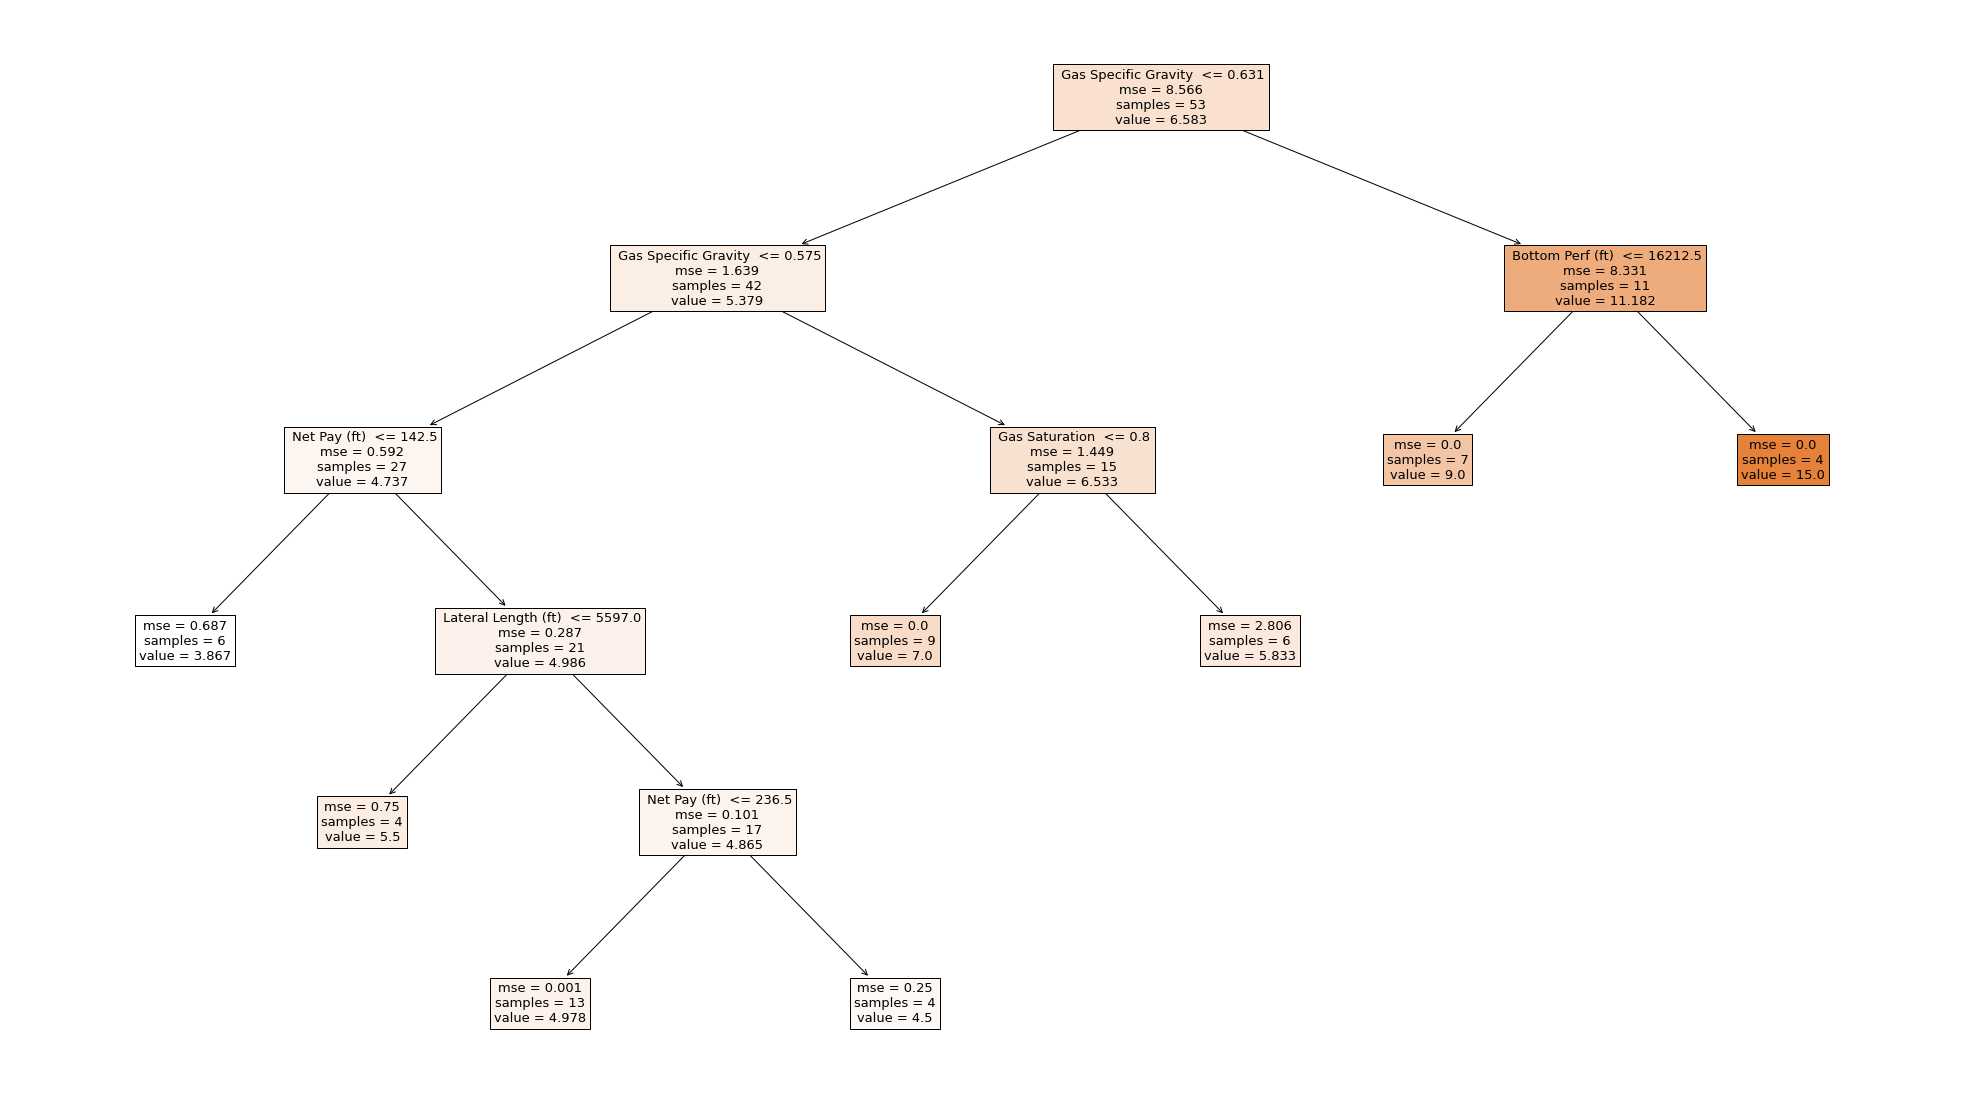

In [19]:
# Visualize decision tree
visualize(dt)

In [20]:
def plot_space(model, netpay, sg, botperf):
  N_matrix = np.empty((10,10))
  for i in range(len(sg)):
    for j in range(len(botperf)):
      # Constant variables except net pay and Sg
      N = predict(model, formation=3, temp=150, netpay=netpay, oilsat=0, 
                  gassat=0.8, sg=sg[i], co2=0.03, n2=0.004, oilapi=30, 
                  tvd=8000, lateral=2000, topperf=6000, botperf=botperf[j])[0]
      N_matrix[i][j] = N  
    
  plt.imshow(N_matrix, origin='lower', aspect='auto', cmap='tab10',
             extent=(min(sg), max(sg), min(botperf), max(botperf)))
  plt.xlabel('Gas Specific Gravity')
  plt.ylabel('Bottom Perforation')
  plt.title(f'Net pay = {netpay} ft', pad=10)    
  plt.colorbar()

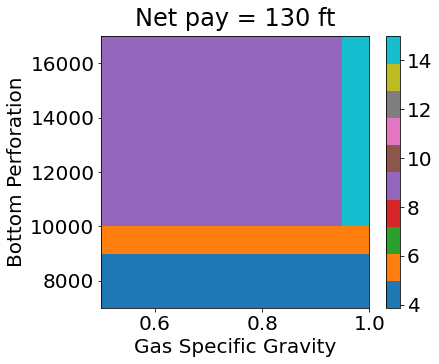

In [21]:
# Range of Sg and bottom perf values
sg = np.linspace(0.5, 1, 10)
botperf = np.linspace(7000, 17000, 10)

# Plot decision space
plt.figure(figsize=(6,5))
plot_space(dt, 130, sg, botperf)
plt.show()